In [ ]:
!pip install pyTelegramBotAPI
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install matplotlib>=3.3.2

BRANCH = 'r1.21.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b7a6dc937b25400f9a2cc85c5c75c183461d6ea851cbf7393bd2d5056e235237
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 45 not 

In [ ]:
from typing import List, Union

import torch
import torchaudio
import soundfile as sf
from omegaconf import DictConfig, ListConfig, OmegaConf
import hydra


In [ ]:
import telebot
from telebot import types
import os
import time
from datetime import date
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sb
import locale
from matplotlib import pyplot as plt
import seaborn as sb


locale.getpreferredencoding = lambda: "UTF-8"

# Loading weights, config and example wav for CTC-model
!wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/emo_model_weights.ckpt
!wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/emo_model_config.yaml
!wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/example.mp3

--2024-05-23 06:39:30--  https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/emo_model_weights.ckpt
Resolving n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)... 37.230.193.192
Connecting to n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)|37.230.193.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 968409626 (924M) [application/octet-stream]
Saving to: ‘emo_model_weights.ckpt’

emo_model_weights.c 100%[===================>] 923.55M  7.62MB/s    in 1m 51s  

2024-05-23 06:41:24 (8.35 MB/s) - ‘emo_model_weights.ckpt’ saved [968409626/968409626]

--2024-05-23 06:41:24--  https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/emo_model_config.yaml
Resolving n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)... 37.230.193.192
Connecting to n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)|37.230.193.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 765 [applicatio

In [ ]:
class SpecScaler(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.log(x.clamp_(1e-9, 1e9))


class GigaAMEmo(torch.nn.Module):
    def __init__(self, conf: Union[DictConfig, ListConfig]):
        super().__init__()
        self.id2name = conf.id2name
        self.feature_extractor = hydra.utils.instantiate(conf.feature_extractor)
        self.conformer = hydra.utils.instantiate(conf.encoder)
        self.linear_head = hydra.utils.instantiate(conf.classification_head)

    def forward(self, features, features_length=None):
        if features.dim() == 2:
            features = features.unsqueeze(0)
        if not features_length:
            features_length = torch.ones(features.shape[0]) * features.shape[-1]
            features_length = features_length.to(features.device)
        encoded, _ = self.conformer(audio_signal=features, length=features_length)
        encoded_pooled = torch.nn.functional.avg_pool1d(
            encoded, kernel_size=encoded.shape[-1]
        ).squeeze(-1)

        logits = self.linear_head(encoded_pooled)
        return logits

    def get_probs(self, audio_path: str) -> List[List[float]]:
        audio_signal, _ = sf.read(audio_path, dtype="float32")
        features = self.feature_extractor(torch.tensor(audio_signal).float().to(next(self.parameters()).device))
        logits = self.forward(features)
        probs = torch.nn.functional.softmax(logits).detach().tolist()
        return probs

In [ ]:
#!sudo apt install portaudio19-dev
#!pip install pyaudio

In [ ]:
model_config = 'emo_model_config.yaml'
model_weights = 'emo_model_weights.ckpt'
audio_path = 'example.mp3'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

conf = OmegaConf.load(model_config)
model = GigaAMEmo(conf)
ckpt = torch.load(model_weights, map_location="cpu")
model.load_state_dict(ckpt, strict=False)
model = model.to(device)

[NeMo W 2024-05-23 06:41:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
      torch.utils._pytree._register_pytree_node(
    
[NeMo W 2024-05-23 06:41:42 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
      torch.utils._pytree._register_pytree_node(
    


In [ ]:
model.eval()
with torch.no_grad():
    probs = model.get_probs('/content/example.mp3')[0]
print(", ".join([f"{model.id2name[i]}: {p:.3f}" for i, p in enumerate(probs)]))

[NeMo W 2024-05-23 06:41:48 nemo_logging:349] <ipython-input-4-06a5deda234a>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
      probs = torch.nn.functional.softmax(logits).detach().tolist()
    


angry: 0.019, sad: 0.137, neutral: 0.735, positive: 0.108


In [ ]:
os.mkdir("specs")
os.mkdir("mels")
os.mkdir("voices")
os.mkdir("vers")

In [ ]:

bot = telebot.TeleBot('7136041425:AAGJRuMRxzM2OtJeuu1-DrAGPuGvjd981oE')


#команды в боте
@bot.message_handler(commands=['start'])
def start(message):
  mess = f'Привет, <b>{message.from_user.first_name} {message.from_user.last_name}</b>,\
  этот бот предназначен для классификации эмоций в аудиоречи. Бот может разобрать 4 эмоции:\
  злость, нейтраль, позитив и грусть. Не записывайте голосовые длиннее 8 секунд(остальное обрезается моделью).\
  \
  Бот также показывает распределение\
  вероятностей по эмоциям, спектрограмму и мел-спектрограмму вашего голосового сообщения.\
  Чтобы начать - просто запишите голосовое сообщение.'
  bot.send_message(message.chat.id, mess, parse_mode='html')

@bot.message_handler(commands=['help'])
def help(message):
  mess = f'Запишите голосовое сообщение, после чего сможете получить прогноз, а также вывести картинку с дополнительной\
  информацией о том как выглядит оцифрованная речь человека. Если захотите сделать новый прогноз, то просто запшите еще одно голосовое сообщение.'
  bot.send_message(message.chat.id, mess, parse_mode='html')


#отслежтваем че пользователь вводит

def show_probabilities_graph(chat_id, probs_dict, message):
    global user_name
    today = date.today()
    today = today.isoformat()
    time = datetime.now().strftime("%H:%M:%S")
    day_time = today + '_' + time.replace(':', '-')
    file_to_model = f'{user_name}_{day_time}'

    plt.figure(figsize=(10, 6))
    sb.barplot(probs_dict, palette='coolwarm')
    plt.xlabel('Эмоция')
    plt.ylabel('Вероятность')
    plt.title('Распределение вероятностей')

    plt.savefig(f'/content/vers/{file_to_model}.jpg')  # Сохраняем график как изображение
    bot.send_photo(chat_id, open(f'/content/vers/{file_to_model}.jpg', 'rb'))  # Отправляем график как фото

def show_spectrogram(chat_id, signal_resampled, message):
    global user_name
    today = date.today()
    today = today.isoformat()
    time = datetime.now().strftime("%H:%M:%S")
    day_time = today + '_' + time.replace(':', '-')
    file_to_model = f'{user_name}_{day_time}'

    spectrograma = torchaudio.transforms.Spectrogram(normalized=True)
    signal = spectrograma(signal_resampled).permute(1, 2, 0)
    spec_np = signal.detach().numpy()


    spec_np = signal.detach().numpy()

    # Отображение спектрограммы
    plt.figure(figsize=(10, 6))
    plt.imshow(spec_np, cmap='hot', origin='lower')
    plt.xlabel('Время')
    plt.ylabel('Частота')
    plt.title('Спектрограмма')
    plt.colorbar()
    plt.grid(False)
    plt.savefig(f'/content/specs/{file_to_model}_spec.jpg')  # Сохраняем график как изображение
    bot.send_photo(chat_id, open(f'/content/specs/{file_to_model}_spec.jpg', 'rb'))  # Отправляем график как фото

def show_mel_spectrogram(chat_id, signal_resampled, message):
    global user_name
    today = date.today()
    today = today.isoformat()
    time = datetime.now().strftime("%H:%M:%S")
    day_time = today + '_' + time.replace(':', '-')
    file_to_model = f'{user_name}_{day_time}'

    mel_spectrograma = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=128)
    signal = mel_spectrograma(signal_resampled).permute(1, 2, 0)
    mel_spec_np = signal.detach().numpy()

    # Отображение мелспектрограммы
    plt.figure(figsize=(10, 6))
    plt.imshow(mel_spec_np, cmap='hot', origin='lower')
    plt.xlabel('Время')
    plt.ylabel('Мел-коэффициент')
    plt.title('Мел-Спектрограмма')
    plt.colorbar()
    plt.grid(False)
    plt.savefig(f'/content/mels/{file_to_model}_melspec.jpg')  # Сохраняем график как изображение
    bot.send_photo(chat_id, open(f'/content/mels/{file_to_model}_melspec.jpg', 'rb'))  # Отправляем график как фото

@bot.callback_query_handler(func=lambda call: call.data == 'probability_distribution')
def handle_probability_distribution(call):
    global probs_dict
    chat_id = call.message.chat.id  # Получаем ID чата из callback
    show_probabilities_graph(chat_id, probs_dict, call.message)

@bot.callback_query_handler(func=lambda call: call.data == 'spectrogram')
def spectrogram(call):
    global signal_resampled
    chat_id = call.message.chat.id  # Получаем ID чата из callback
    show_spectrogram(chat_id, signal_resampled, call.message)

@bot.callback_query_handler(func=lambda call: call.data == 'mel_spectrogram')
def mel_spectrogram(call):
    global signal_resampled
    chat_id = call.message.chat.id  # Получаем ID чата из callback
    show_mel_spectrogram(chat_id, signal_resampled, call.message)

@bot.message_handler(content_types=['voice'])
def get_user_voice(message):
    global probs_dict, user_name, signal_resampled
    markup = types.InlineKeyboardMarkup()
    markup.add(types.InlineKeyboardButton(text="Спектрограмма", callback_data="spectrogram"))
    markup.add(types.InlineKeyboardButton(text="Распределение вероятностей", callback_data="probability_distribution"))
    markup.add(types.InlineKeyboardButton(text="Мел-спектрограмма", callback_data="mel_spectrogram"))

    file_id = message.voice.file_id
    file_info = bot.get_file(file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    today = date.today()
    today = today.isoformat()
    time = datetime.now().strftime("%H:%M:%S")
    day_time = today+'_'+time.replace(':', '-')
    file_to_model = f'{message.from_user.first_name}_{message.from_user.last_name}_{day_time}'
    file_path = os.path.join('voices', f'{file_to_model}.wav')  # Путь для сохранения файла
    with open(file_path, 'wb') as new_file:
        new_file.write(downloaded_file)
    signal, sr = torchaudio.load(file_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    signal_resampled = resampler(signal)

    # Сохранение аудиофайла с новой частотой дискретизации
    torchaudio.save(file_path, signal_resampled, 16000)

    model.eval()
    with torch.no_grad():
      probs = model.get_probs(file_path)[0]
    text = ", ".join([f"{model.id2name[i]}: {p:.3f}" for i, p in enumerate(probs)])
    emotions = ['Злость', 'Грусть', 'Нейтраль', 'Позитив']
    probs_dict = {emotion: float(prob) for emotion, prob in zip(emotions, probs)}
    max_emotion = max(probs_dict, key=probs_dict.get)
    max_value = probs_dict[max_emotion]
    user_name = f'{message.from_user.first_name}_{message.from_user.last_name}'


    em = f"Ваша эмоция: {max_emotion}"



    bot.send_message(message.chat.id, em, reply_markup=markup)

@bot.message_handler(content_types=['text'])
def get_user_text(message):
  markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
  help_button = types.KeyboardButton('/help')
  start = types.KeyboardButton('/start')
  markup.add(help_button, start)
  help = 'Запишите голосовое сообщение'
  bot.send_message(message.chat.id, help, parse_mode='html', reply_markup=markup)


bot.polling(non_stop=True)

[NeMo W 2024-05-23 06:41:55 nemo_logging:349] <ipython-input-4-06a5deda234a>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
      probs = torch.nn.functional.softmax(logits).detach().tolist()
    


In [ ]:
model.eval()
with torch.no_grad():
  probs = model.get_probs('/content/voices/Валерия_None_2024-05-16_13-27-29.wav')[0]
text = ", ".join([f"{model.id2name[i]}: {p:.3f}" for i, p in enumerate(probs)])
emotions = ['злость', 'грусть', 'нейтраль', 'прозитив']
probs_dict = {emotion: float(prob) for emotion, prob in zip(emotions, probs)}

print(probs_dict)
print(text)

[NeMo W 2024-05-16 15:04:09 nemo_logging:349] <ipython-input-61-06a5deda234a>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
      probs = torch.nn.functional.softmax(logits).detach().tolist()
    


{'злость': 5.04490417370107e-05, 'грусть': 0.0003864375175908208, 'нейтраль': 0.0003784660075325519, 'прозитив': 0.9991846680641174}
angry: 0.000, sad: 0.000, neutral: 0.000, positive: 0.999


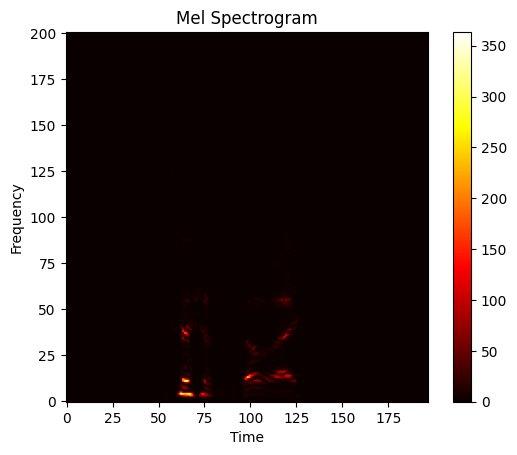

In [ ]:
mel_spectrogram = torchaudio.transforms.Spectrogram(sample_rate=sr, n_fft=1024, hop_length=512, n_mels=128)
signal, sr = torchaudio.load('/content/voices/Evgeny_Pankratov_2024-05-16_13-53-14.wav')
signal = mel_spectrogram(signal).permute(1, 2, 0)


mel_spec_np = signal.detach().numpy()

# Отображение мелспектрограммы

plt.imshow(mel_spec_np, cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.grid(False)
plt.show()